100%|██████████| 2000/2000 [12:48<00:00,  2.60it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 541ms/step - accuracy: 0.0209 - loss: 4.1171 - val_accuracy: 0.0125 - val_loss: 3.9801
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 524ms/step - accuracy: 0.0267 - loss: 3.8839 - val_accuracy: 0.0100 - val_loss: 3.8810
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 557ms/step - accuracy: 0.0232 - loss: 3.8325 - val_accuracy: 0.0350 - val_loss: 3.7251
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 542ms/step - accuracy: 0.0549 - loss: 3.6650 - val_accuracy: 0.0675 - val_loss: 3.5036
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 517ms/step - accuracy: 0.0826 - loss: 3.4164 - val_accuracy: 0.1425 - val_loss: 3.3435
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 517ms/step - accuracy: 0.1685 - loss: 3.1241 - val_accuracy: 0.1725 - val_loss: 2.9881
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 576ms/step - accuracy: 0.1793 - loss: 2.8532 - val_accuracy: 0.3150 - val_loss: 2.6130
Epoch 8/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 538ms/step - accuracy: 0.2724 - loss: 2.4730 - 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
              precision    recall  f1-score   support

           0     0.7143    0.8333    0.7692         6
           1     0.7143    0.8333    0.7692         6
           2     0.3750    0.3333    0.3529         9
           3     0.8750    0.5385    0.6667        13
           4     0.8000    0.7273    0.7619        11
           5     0.8000    0.6667    0.7273        12
           6     0.6667    0.1667    0.2667        12
           7     0.6250    0.8333    0.7143         6
           8     0.5556    0.5000    0.5263        10
           9     0.6667    0.6667    0.6667         6
          10     0.5000    0.6000    0.5455         5
          11     0.7000    0.5833    0.6364        12
          12     0.4444    0.4444    0.4444         9
          13     0.3750    0.5000    0.4286         6
          14     0.7143    0.8333    0.7692         6
          15     0.5714    0.2857    0.3810        14
          16     0.7778    0.7778    0.7778         9
    

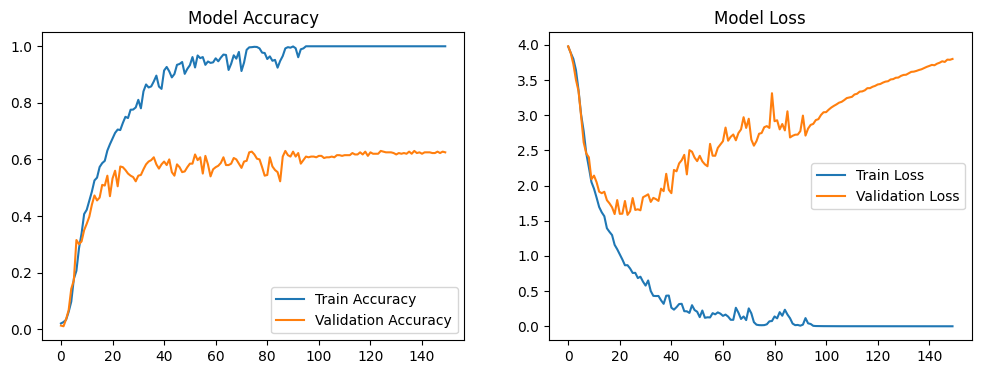

Final Test Accuracy: 0.6250
ESC-50 pre-trained model saved successfully!


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

# Load ESC-50 metadata
esc50_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/meta/esc50.csv"
esc50_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/audio"

metadata = pd.read_csv(esc50_csv_path)

# Function to extract Log-Mel Spectrogram (LM) feature
def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        def resize_feature(feature, target_size):
            return np.pad(feature, ((0, max(0, target_size[0] - feature.shape[0])),
                                     (0, max(0, target_size[1] - feature.shape[1]))), mode='constant')

        mel_spec = resize_feature(mel_spec, target_size)
        stacked_features = np.expand_dims(mel_spec, axis=-1)  # Convert to 3D shape for CNN input
        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Prepare dataset
X, y = [], []
for i in tqdm(range(len(metadata))):
    file_path = os.path.join(esc50_audio_dir, metadata.loc[i, "filename"])
    label = metadata.loc[i, "target"]
    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array(X)
y = to_categorical(y, num_classes=50)

# Resize images (Ensure uniformity)
X_resized = np.array([tf.image.resize(img, (128, 128)).numpy() for img in X])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)

# Define CNN model
def create_cnn_model(input_shape, num_classes=50):
    model = Sequential([
        Conv2D(32, (2, 2), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(32, (2, 2), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (2, 2), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (2, 2), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train the CNN model
input_shape = (128, 128, 1)
num_classes = 50
model = create_cnn_model(input_shape, num_classes)

# Train model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
train_loss, train_accuracy = model.evaluate(X_train, y_train)
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute Precision, Recall, and F1-score
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:")
print(report)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

# Print final evaluation
print(f"Final Test Accuracy: {val_accuracy:.4f}")


# Save the pre-trained model
model.save("/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_LM_esc50.h5")
print("ESC-50 pre-trained model saved successfully!")



Pre-trained ESC-50 model loaded successfully!


 41%|████      | 3553/8732 [02:27<02:17, 37.54it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8326/8732 [05:23<00:09, 43.60it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [05:36<00:00, 25.98it/s]


Shape of feature dataset: (8732, 128, 128, 1)
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 120s 530ms/step - accuracy: 0.2902 - loss: 2.5163 - val_accuracy: 0.5415 - val_loss: 1.2847
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 116s 531ms/step - accuracy: 0.5857 - loss: 1.1974 - val_accuracy: 0.6239 - val_loss: 1.0736
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 118s 539ms/step - accuracy: 0.6545 - loss: 1.0122 - val_accuracy: 0.6726 - val_loss: 0.9544
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 138s 521ms/step - accuracy: 0.7065 - loss: 0.8899 - val_accuracy: 0.7172 - val_loss: 0.8830
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 154s 577ms/step - accuracy: 0.7373 - loss: 0.8240 - val_accuracy: 0.7310 - val_loss: 0.8128
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 141s 571ms/step - accuracy: 0.7538 - loss: 0.7524 - val_accuracy: 0.7470 - val_loss: 0.7650
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 139s 559ms/step - accuracy: 0.7820 - loss: 0.6957 - val_accuracy: 0.7579 - val_loss: 0.7223
Epoch 8/50
219/219 ━━━━━━━━━━━

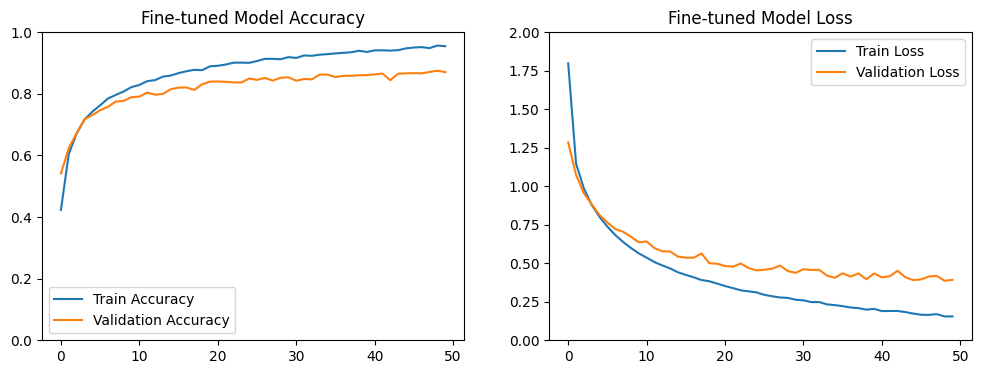

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

# Load the pre-trained ESC-50 model
model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_LM_esc50.h5"
model = load_model(model_path)
print("Pre-trained ESC-50 model loaded successfully!")

# Load UrbanSound8K metadata
urbansound_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
urbansound_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"

metadata = pd.read_csv(urbansound_csv_path)

# Function to extract Log-Mel Spectrogram features
def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Ensure uniform size (128, 128)
        mel_spec = librosa.util.fix_length(mel_spec, size=target_size[1], axis=1)
        mel_spec = librosa.util.fix_length(mel_spec, size=target_size[0], axis=0)

        stacked_features = np.expand_dims(mel_spec, axis=-1)  # Convert to 3D shape for CNN input
        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Prepare dataset
X, y = [], []
for i in tqdm(range(len(metadata))):
    file_name = metadata.loc[i, "slice_file_name"]
    folder = f"fold{metadata.loc[i, 'fold']}"
    file_path = os.path.join(urbansound_audio_dir, folder, file_name)
    label = metadata.loc[i, "classID"]

    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

# Convert lists to NumPy arrays, ensuring shape consistency
X = np.array([img for img in X if img is not None])
y = np.array(y)

# One-hot encode labels
y = to_categorical(y, num_classes=10)  # UrbanSound8K has 10 classes

# Print dataset shape
print(f"Shape of feature dataset: {X.shape}")  # Should be (num_samples, 128, 128, 1)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modify the last layer to match UrbanSound8K's 10 classes
num_classes = 10
model.pop()  # Remove last layer
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the pre-trained model on UrbanSound8K dataset
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the fine-tuned model
train_loss, train_accuracy = model.evaluate(X_train, y_train)
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute Precision, Recall, and F1-score
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:")
print(report)



# Plot training history with customized y-axis ranges
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim(0, 1)  # Set y-axis range for accuracy
plt.legend()
plt.title('Fine-tuned Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim(0, 2)  # Set y-axis range for loss
plt.legend()
plt.title('Fine-tuned Model Loss')

plt.show()


Pre-trained ESC-50 model loaded successfully!


 41%|████      | 3552/8732 [03:39<04:02, 21.38it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8323/8732 [08:20<00:08, 48.59it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [08:35<00:00, 16.94it/s]


Shape of feature dataset: (8732, 128, 128, 1)
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 122s 543ms/step - accuracy: 0.2977 - loss: 2.3864 - val_accuracy: 0.5661 - val_loss: 1.2701
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 141s 541ms/step - accuracy: 0.5908 - loss: 1.1803 - val_accuracy: 0.6388 - val_loss: 1.0599
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 143s 547ms/step - accuracy: 0.6608 - loss: 1.0244 - val_accuracy: 0.6714 - val_loss: 0.9743
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 142s 544ms/step - accuracy: 0.6948 - loss: 0.9085 - val_accuracy: 0.7195 - val_loss: 0.8689
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 140s 536ms/step - accuracy: 0.7431 - loss: 0.7928 - val_accuracy: 0.7338 - val_loss: 0.7948
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 141s 530ms/step - accuracy: 0.7503 - loss: 0.7550 - val_accuracy: 0.7619 - val_loss: 0.7466
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 151s 570ms/step - accuracy: 0.7764 - loss: 0.6919 - val_accuracy: 0.7790 - val_loss: 0.6888
Epoch 8/50
219/219 ━━━━━━━━━━━

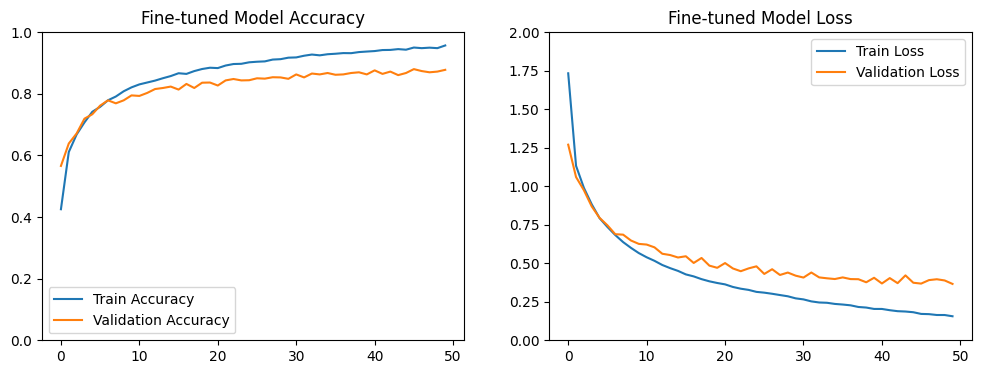

Training history saved as .npy files.
CNN1 training history saved!


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

# Load the pre-trained ESC-50 model
model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_LM_esc50.h5"
model = load_model(model_path)
print("Pre-trained ESC-50 model loaded successfully!")

# Load UrbanSound8K metadata
urbansound_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
urbansound_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"

metadata = pd.read_csv(urbansound_csv_path)

# Function to extract Log-Mel Spectrogram features
def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Ensure uniform size (128, 128)
        mel_spec = librosa.util.fix_length(mel_spec, size=target_size[1], axis=1)
        mel_spec = librosa.util.fix_length(mel_spec, size=target_size[0], axis=0)

        stacked_features = np.expand_dims(mel_spec, axis=-1)  # Convert to 3D shape for CNN input
        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Prepare dataset
X, y = [], []
for i in tqdm(range(len(metadata))):
    file_name = metadata.loc[i, "slice_file_name"]
    folder = f"fold{metadata.loc[i, 'fold']}"
    file_path = os.path.join(urbansound_audio_dir, folder, file_name)
    label = metadata.loc[i, "classID"]

    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

# Convert lists to NumPy arrays, ensuring shape consistency
X = np.array([img for img in X if img is not None])
y = np.array(y)

# One-hot encode labels
y = to_categorical(y, num_classes=10)  # UrbanSound8K has 10 classes

# Print dataset shape
print(f"Shape of feature dataset: {X.shape}")  # Should be (num_samples, 128, 128, 1)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modify the last layer to match UrbanSound8K's 10 classes
num_classes = 10
model.pop()  # Remove last layer
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the pre-trained model on UrbanSound8K dataset
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the fine-tuned model
train_loss, train_accuracy = model.evaluate(X_train, y_train)
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute Precision, Recall, and F1-score
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:")
print(report)



# Plot training history with customized y-axis ranges
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim(0, 1)  # Set y-axis range for accuracy
plt.legend()
plt.title('Fine-tuned Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim(0, 2)  # Set y-axis range for loss
plt.legend()
plt.title('Fine-tuned Model Loss')

plt.show()


# Save training history to .npy files
np.save("cnn1_train_acc.npy", np.array(history.history['accuracy']))
np.save("cnn1_val_acc.npy",   np.array(history.history['val_accuracy']))
np.save("cnn1_train_loss.npy", np.array(history.history['loss']))
np.save("cnn1_val_loss.npy",   np.array(history.history['val_loss']))

print("Training history saved as .npy files.")


# SAVE CNN1 HISTORY AFTER TRAINING
import numpy as np

np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn1_LM_train_acc.npy", history.history['accuracy'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn1_LM_val_acc.npy", history.history['val_accuracy'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn1_LM_train_loss.npy", history.history['loss'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn1_LM_val_loss.npy", history.history['val_loss'])

print("CNN1 training history saved!")

